In [164]:
#python 2 and 3 comptibility
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import json
import io
import gzip
import base64
from astropy.io import fits
import matplotlib.pylab as plt
import pickle as pkl
import numpy as np
%matplotlib inline

data_path = '/home/ereyes/Alerce/ZTF_7_18'

#with open('/home/asceta/LRPpaper/datasets/ZTF/reals.pkl', 'rb') as f:
#    reals = pkl.load(f)
#with open('/home/asceta/LRPpaper/datasets/ZTF/bogus.pkl', 'rb') as f:
#    bogus = pkl.load(f)
    
#print('Number of reals: %d' %len(reals))
#print('Number of bogus: %d' %len(bogus))
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [8, 4]

In [165]:
def json2list(path):
    #load json
    with open(path, "r") as f:
        dataset = json.load(f)
    
    samples_list = []
    for i in range(len(dataset['query_result'])):

        channels = []
        for k, imstr in enumerate(['Template', 'Science', 'Difference']):
            stamp = dataset['query_result'][i]['cutout'+imstr]['stampData']
            stamp = base64.b64decode(stamp["$binary"].encode())

            with gzip.open(io.BytesIO(stamp), 'rb') as f:
                with fits.open(io.BytesIO(f.read())) as hdul:
                    img = hdul[0].data
                    channels.append(img)
        samples_list.append(np.array(channels))
    return samples_list

In [143]:
def check_samples_shapes(samples):
    miss_shaped_sample_idx = []
    for i in range(len(samples)):
        sample = samples[i]
        if sample.shape[0]!=3 or sample.shape[1]!=63 or sample.shape[2]!=63:
            #print("sample %i of shape %s" %(i,str(sample.shape)))
            miss_shaped_sample_idx.append(i)
    return miss_shaped_sample_idx

#misshaped_reals = check_samples_shapes(reals)
#misshaped_bogus = check_samples_shapes(bogus)
 
#print('Number of misshaped reals: %d' %len(misshaped_reals))
#print('Number of misshaped bogus: %d' %len(misshaped_bogus))

In [144]:
#TODO padding non trivial by determining center

def clean_misshaped(samples):
    miss_shaped_sample_idx = check_samples_shapes(samples)
    print('%d misshaped samples removed' %len(miss_shaped_sample_idx))
    for index in sorted(miss_shaped_sample_idx, reverse=True):
        samples.pop(index)
    return np.moveaxis(np.array(samples), 1, -1)

#reals_clean = clean_misshaped(reals)
#bogus_clean = clean_misshaped(bogus)

In [145]:
def crop_at_center(sample_numpy, cropsize=21):
    center = int((sample_numpy.shape[1]-1)/2)
    crop_side = int((cropsize-1)/2)
    crop_begin = center-crop_side
    crop_end = center+crop_side+1
    #print(center)
    #print(crop_begin, crop_end)
    return sample_numpy[:,crop_begin:crop_end,crop_begin:crop_end,:]

#reals_croped = crop_at_center(clean_misshaped(reals))
#bogus_croped = crop_at_center(clean_misshaped(bogus))

In [146]:
def zero_fill_nans(samples_numpy):
    samples_with_nan_idx = []
    for i in range(samples_numpy.shape[0]):
        if(np.isnan(samples_numpy[i,...]).any()):
            samples_with_nan_idx.append(i)
    print('%d samples with NaNs' %len(samples_with_nan_idx))
    return np.nan_to_num(samples_numpy)

#reals_croped_padded = zero_fill_nans(crop_at_center(clean_misshaped(reals)))
#bogus_croped_padded = zero_fill_nans(crop_at_center(clean_misshaped(bogus)))

In [147]:
def remove_nans(samples_numpy):
    samples_no_nan = []
    count = 0
    for i in range(samples_numpy.shape[0]):
        if not (np.isnan(samples_numpy[i,...]).any()):
            samples_no_nan.append(samples_numpy[i,...])
    #print('%d samples with NaNs' %len(samples_with_nan_idx))
    return np.array(samples_no_nan)

#reals_croped_padded = zero_fill_nans(crop_at_center(clean_misshaped(reals)))
#bogus_croped_padded = zero_fill_nans(crop_at_center(clean_misshaped(bogus)))

In [148]:
#normalice each channel individually. Every channel of every sample will be 0-1 normalized
def normalize_01(samples_numpy):
    for i in range(samples_numpy.shape[0]):
        for j in range(samples_numpy.shape[3]):
            sample = samples_numpy[i,:,:,j]
            normalized_sample = (sample-np.min(sample))/np.max(sample-np.min(sample))
            samples_numpy[i,:,:,j] = normalized_sample
    return samples_numpy



In [149]:
def print_sample(img):
    fig = plt.figure()
    for k, imstr in enumerate(['Template', 'Science', 'Difference']):
        ax = fig.add_subplot(1,3,k+1)
        ax.axis('off')
        ax.set_title(imstr)
        ax.matshow(img[...,k])
        

# preprocessing

In [150]:
reals = remove_nans(clean_misshaped(json2list(data_path+'/broker_reals.json')))
#bogus_croped_padded_norm = normalize_01(zero_fill_nans(crop_at_center(clean_misshaped(json2list(data_path+'/broker_bogus.json')))))

118 misshaped samples removed


In [151]:
reals.shape

(6054, 63, 63, 3)

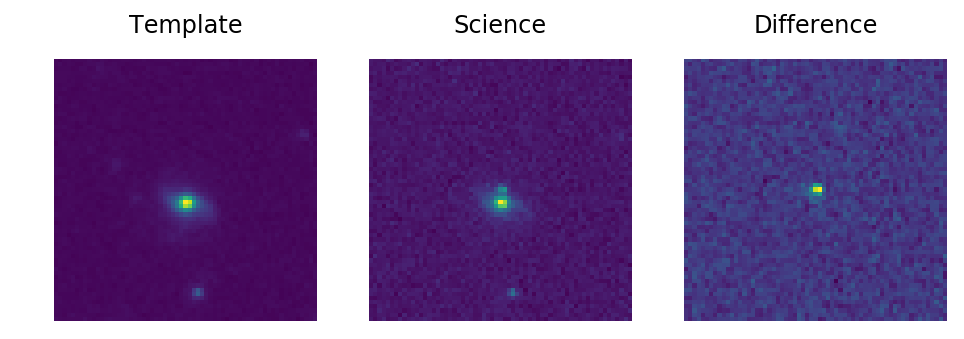

In [166]:
print_sample(reals[1050,...])

In [167]:
np.max(reals)

67038.445

In [168]:
np.min(reals)

-6394.199

In [169]:
np.mean(reals[...,2])

0.82452476

# PSFS Visual

In [305]:
difference = reals[...,2]
sample = 2
n = 1.5
difference[sample].shape

(63, 63)

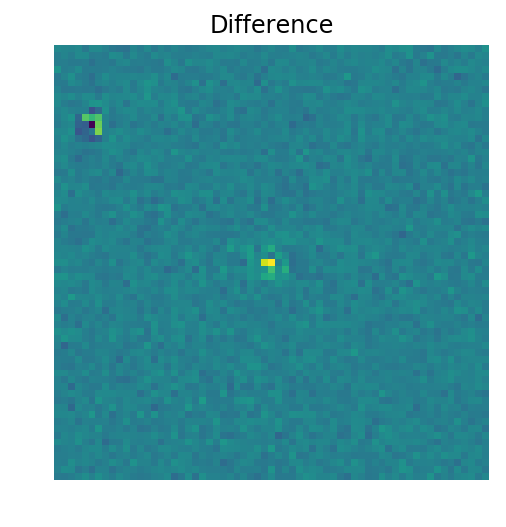

In [306]:
plt.imshow(difference[sample])
plt.axis('off')
plt.title('Difference')
plt.show()

In [307]:

sigma = np.std(difference[sample], axis=(0,1))
n_sigma = n*sigma
n_sigma

11.422096252441406

In [308]:
x_axis = difference[sample][int(np.round(difference[sample].shape[0]/2)),:]
x_axis.shape

(63,)

In [309]:
y_axis = difference[sample][:,int(np.round(difference[sample].shape[0]/2))]
y_axis.shape

(63,)

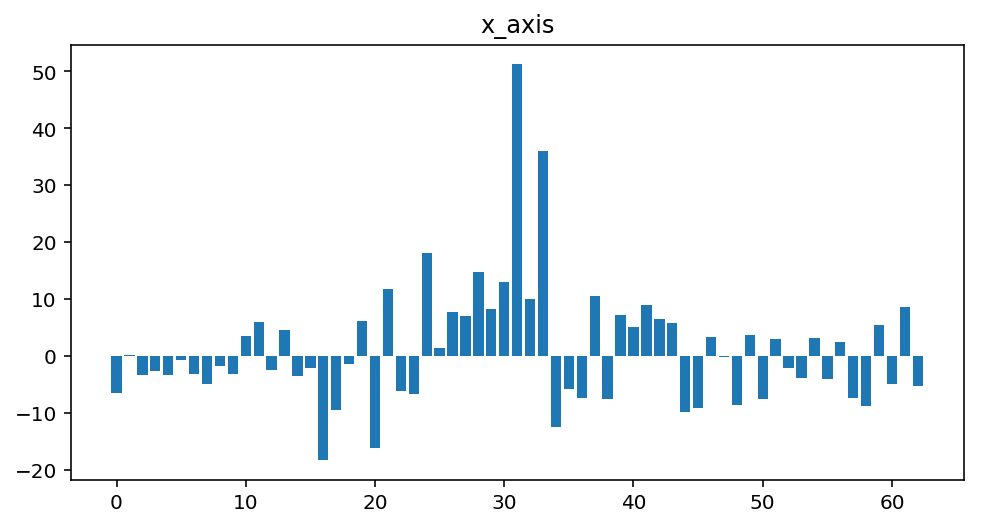

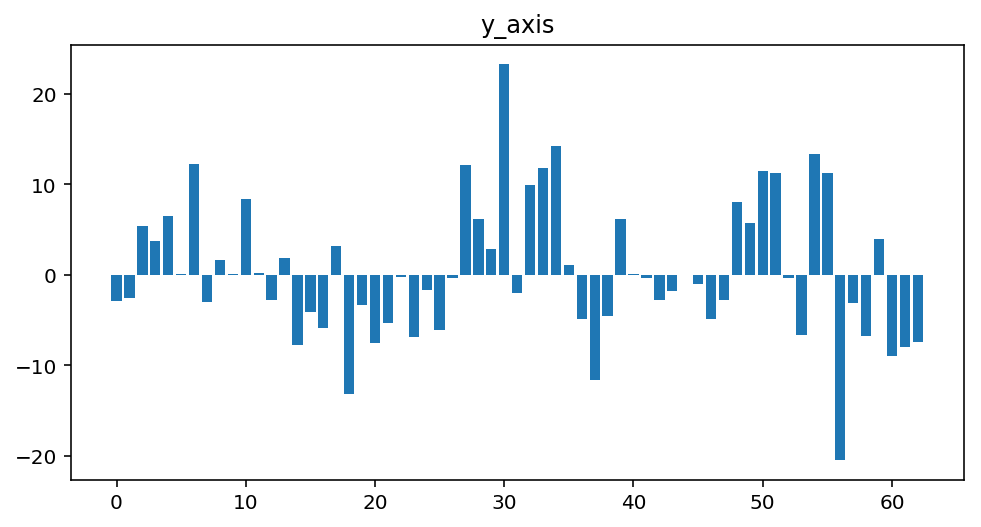

In [310]:
plt.bar(np.arange(0,int(np.round(difference[sample].shape[0]))), x_axis)
plt.title('x_axis')
plt.show()
plt.bar(np.arange(0,int(np.round(difference[sample].shape[0]))), y_axis)
plt.title('y_axis')
plt.show()

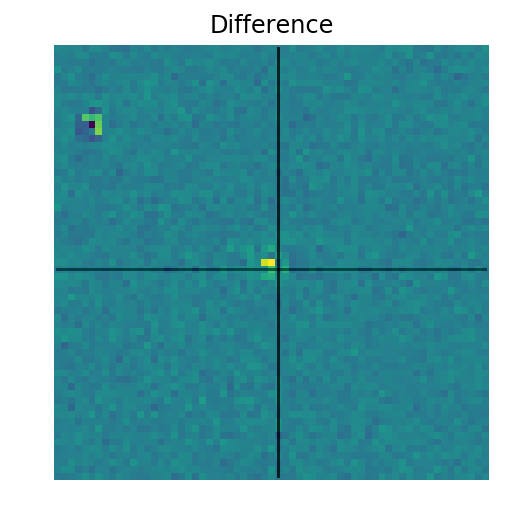

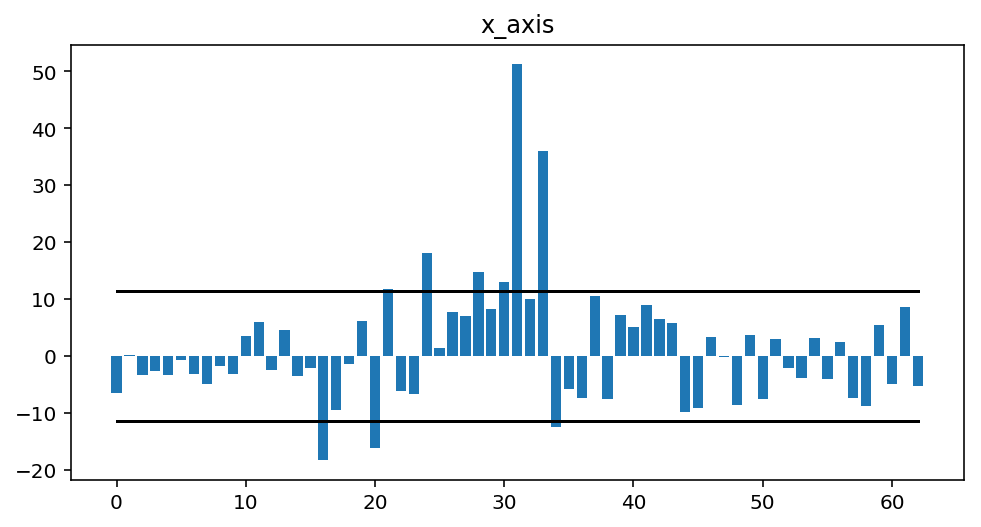

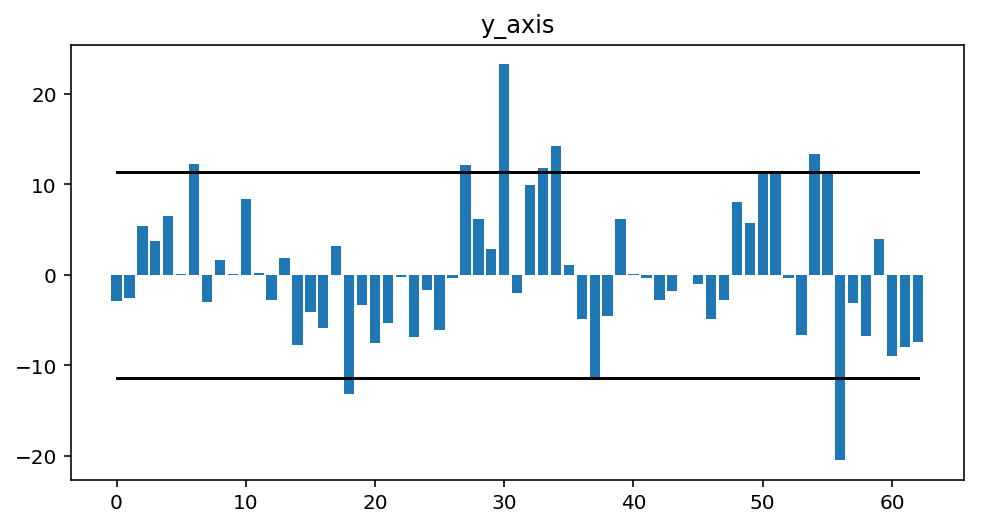

In [311]:
difference_sample = difference[sample].copy()
#difference_sample[:,int(np.round(difference[sample].shape[0]/2))] = 0
#difference_sample[int(np.round(difference[sample].shape[0]/2)),:] = 0
#plt.plot(a*np.cos(theta), a*np.sin(theta), color='black')
x_pos = np.full(difference[sample].shape,int(np.round(difference[sample].shape[0]/2)))
y_pos = np.full(difference[sample].shape,int(np.round(difference[sample].shape[0]/2)))
line=np.arange(0,int(np.round(difference[sample].shape[0])))
plt.plot(line, x_pos, color='black', alpha=0.008)
plt.plot(y_pos, line, color='black', alpha=0.015)

plt.imshow(difference_sample)
plt.axis('off')
plt.title('Difference')
plt.show()

n_sigma_line = np.full(difference[sample].shape, n_sigma)
plt.bar(np.arange(0,int(np.round(difference[sample].shape[0]))), x_axis)
plt.plot(line, n_sigma_line, color='black')
plt.plot(line, -1*n_sigma_line, color='black')
plt.title('x_axis')
plt.show()

plt.bar(np.arange(0,int(np.round(difference[sample].shape[0]))), y_axis)
plt.plot(line, n_sigma_line, color='black')
plt.plot(line, -1*n_sigma_line, color='black')
plt.title('y_axis')
plt.show()

In [312]:
PSF = difference_sample*(difference_sample>n_sigma)
PSF.shape

(63, 63)

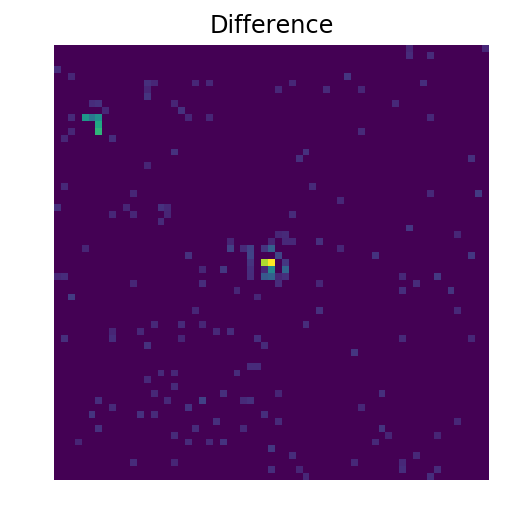

In [313]:
plt.imshow(PSF)
plt.axis('off')
plt.title('Difference')
plt.show()

In [314]:
sigma_psf2 = np.std(PSF, axis=(0,1))
n_sigma_psf2 = n*sigma_psf2
n_sigma_psf2

6.680735349655151

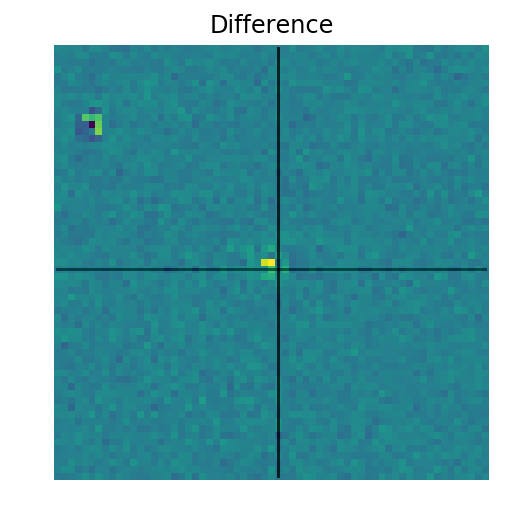

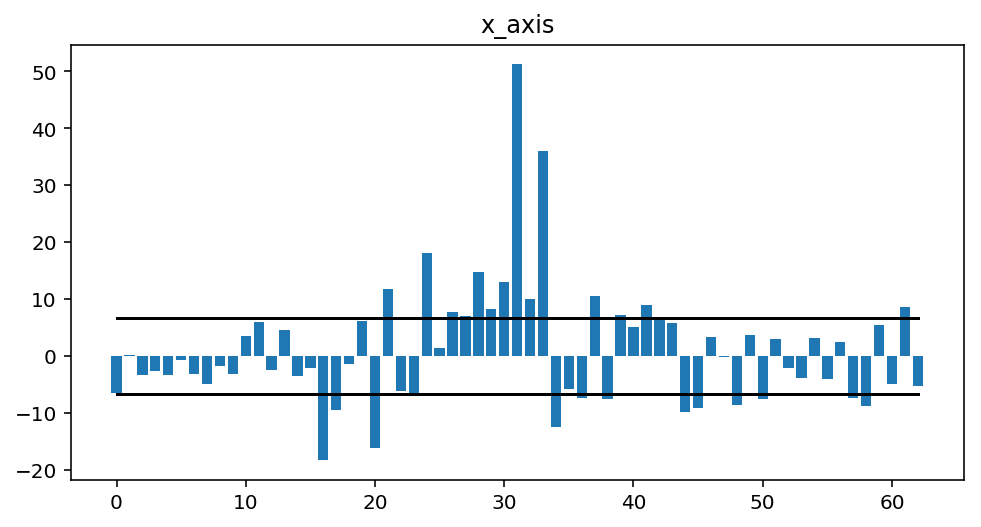

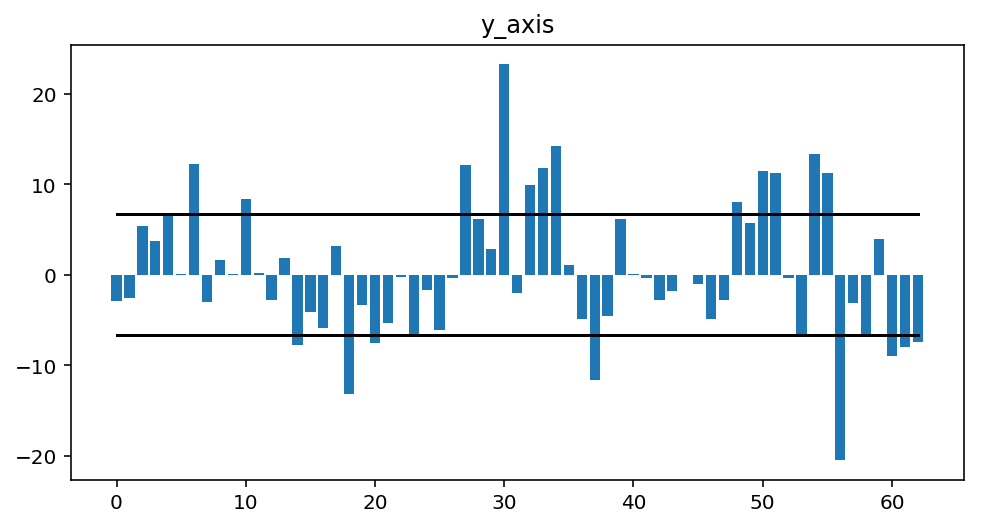

In [315]:
plt.imshow(difference_sample)
plt.axis('off')
plt.title('Difference')

plt.plot(line, x_pos, color='black', alpha=0.008)
plt.plot(y_pos, line, color='black', alpha=0.015)
plt.show()

n_sigma_line = np.full(difference[sample].shape, n_sigma_psf2)
plt.bar(np.arange(0,int(np.round(difference[sample].shape[0]))), x_axis)
plt.plot(line, n_sigma_line, color='black')
plt.plot(line, -1*n_sigma_line, color='black')
plt.title('x_axis')
plt.show()

plt.bar(np.arange(0,int(np.round(difference[sample].shape[0]))), y_axis)
plt.plot(line, n_sigma_line, color='black')
plt.plot(line, -1*n_sigma_line, color='black')
plt.title('y_axis')
plt.show()

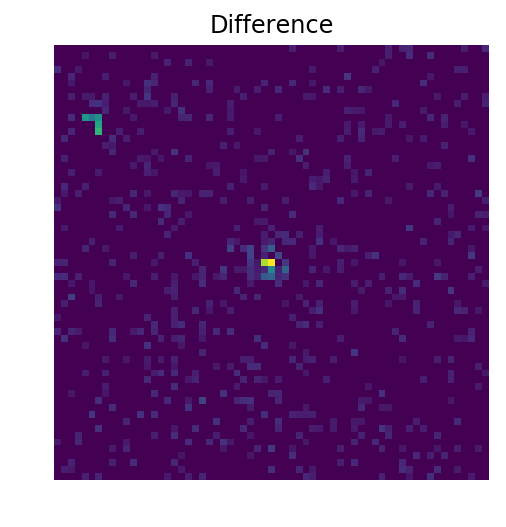

In [316]:
PSF2 = difference_sample*(difference_sample>n_sigma_psf2)
plt.imshow(PSF2)
plt.axis('off')
plt.title('Difference')
plt.show()

In [317]:
sigma_psf3 = np.std(PSF2, axis=(0,1))
n_sigma_psf3 = n*sigma_psf3
n_sigma_psf3

7.578568696975708

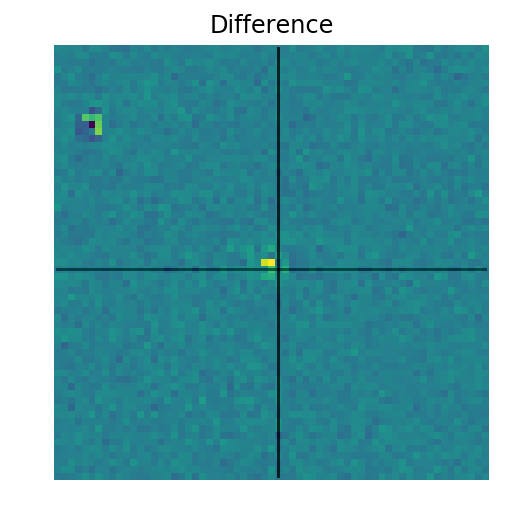

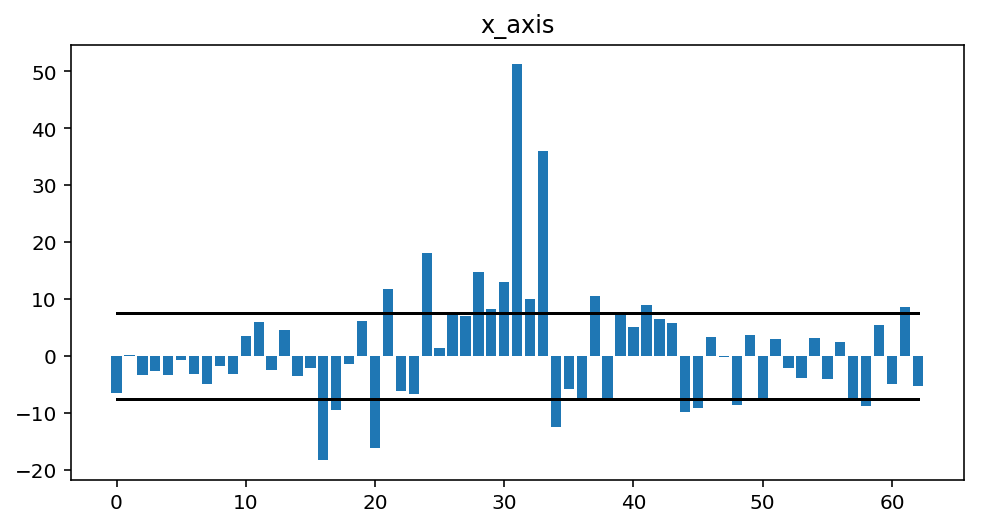

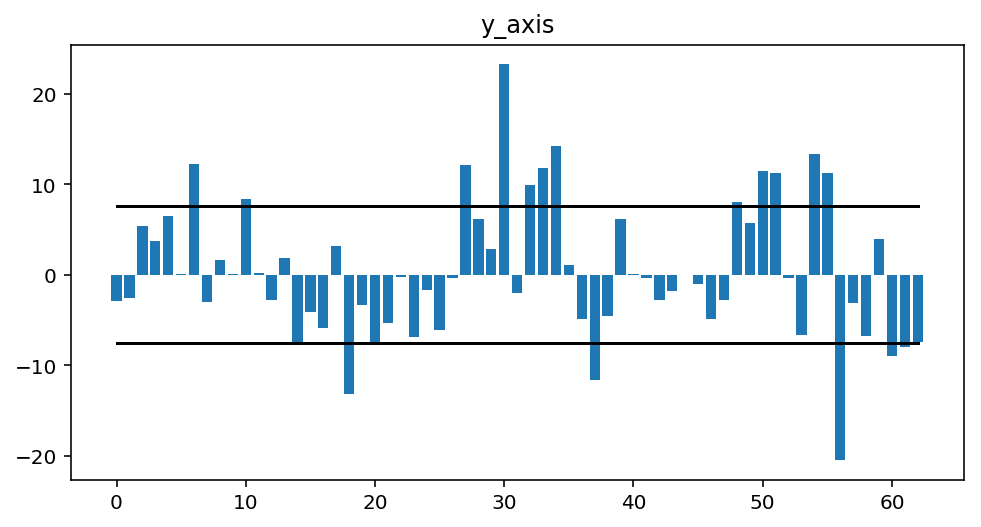

In [318]:
plt.imshow(difference_sample)
plt.axis('off')
plt.title('Difference')

plt.plot(line, x_pos, color='black', alpha=0.008)
plt.plot(y_pos, line, color='black', alpha=0.015)
plt.show()

n_sigma_line = np.full(difference[sample].shape, n_sigma_psf3)
plt.bar(np.arange(0,int(np.round(difference[sample].shape[0]))), x_axis)
plt.plot(line, n_sigma_line, color='black')
plt.plot(line, -1*n_sigma_line, color='black')
plt.title('x_axis')
plt.show()

plt.bar(np.arange(0,int(np.round(difference[sample].shape[0]))), y_axis)
plt.plot(line, n_sigma_line, color='black')
plt.plot(line, -1*n_sigma_line, color='black')
plt.title('y_axis')
plt.show()

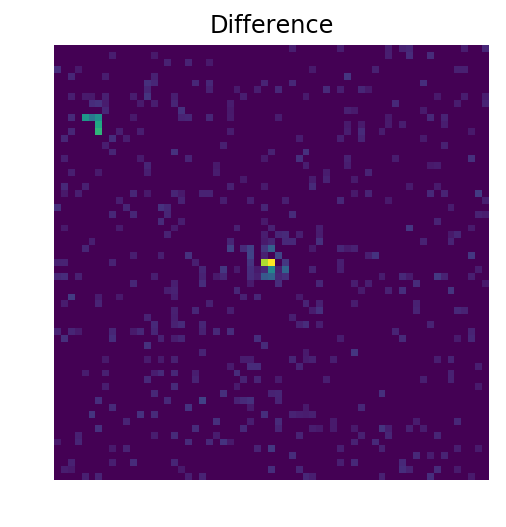

In [319]:
PSF3 = difference_sample*(difference_sample>n_sigma_psf3)
plt.imshow(PSF3)
plt.axis('off')
plt.title('Difference')
plt.show()

In [320]:
sigma_psf4 = np.std(PSF3, axis=(0,1))
n_sigma_psf4 = n*sigma_psf4
n_sigma_psf4

7.466618299484253

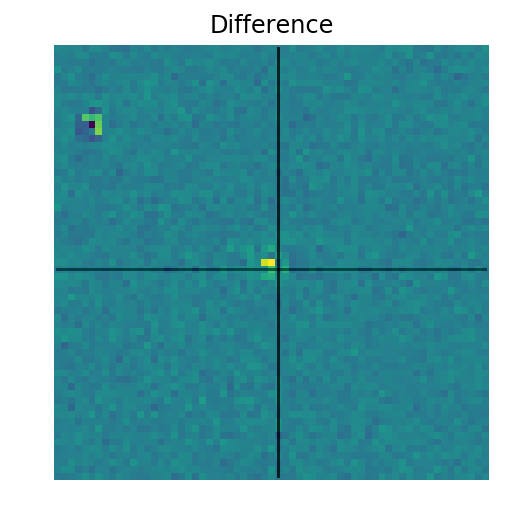

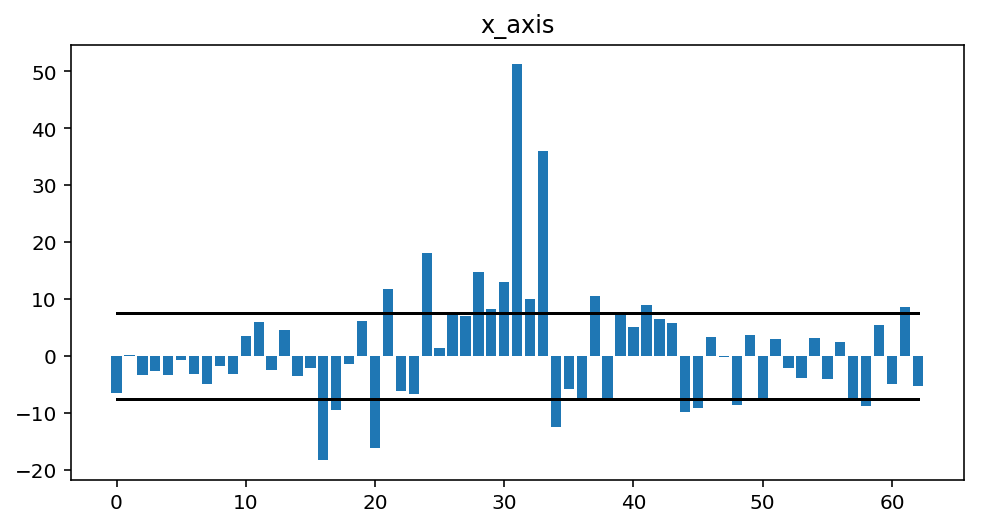

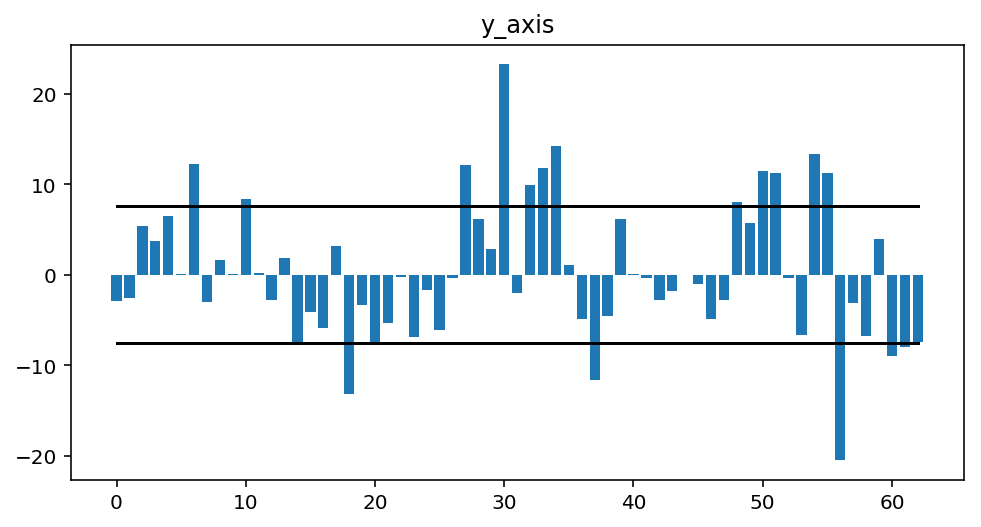

In [321]:
plt.imshow(difference_sample)
plt.axis('off')
plt.title('Difference')

plt.plot(line, x_pos, color='black', alpha=0.008)
plt.plot(y_pos, line, color='black', alpha=0.015)
plt.show()

n_sigma_line = np.full(difference[sample].shape, n_sigma_psf3)
plt.bar(np.arange(0,int(np.round(difference[sample].shape[0]))), x_axis)
plt.plot(line, n_sigma_line, color='black')
plt.plot(line, -1*n_sigma_line, color='black')
plt.title('x_axis')
plt.show()

plt.bar(np.arange(0,int(np.round(difference[sample].shape[0]))), y_axis)
plt.plot(line, n_sigma_line, color='black')
plt.plot(line, -1*n_sigma_line, color='black')
plt.title('y_axis')
plt.show()

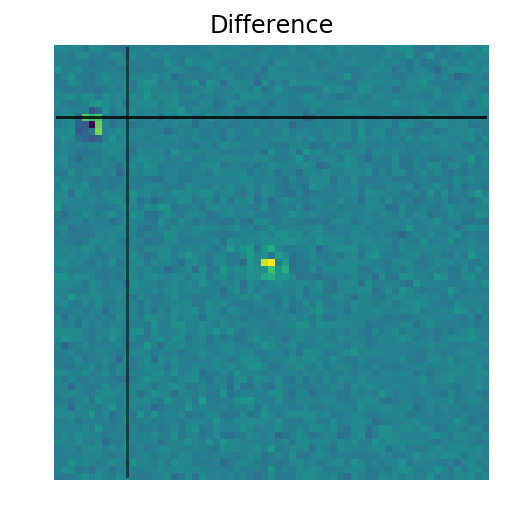

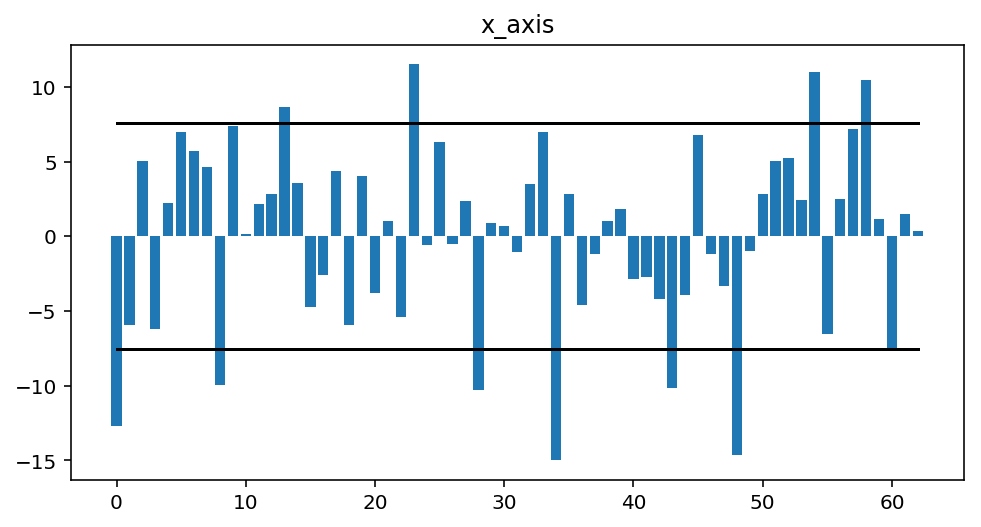

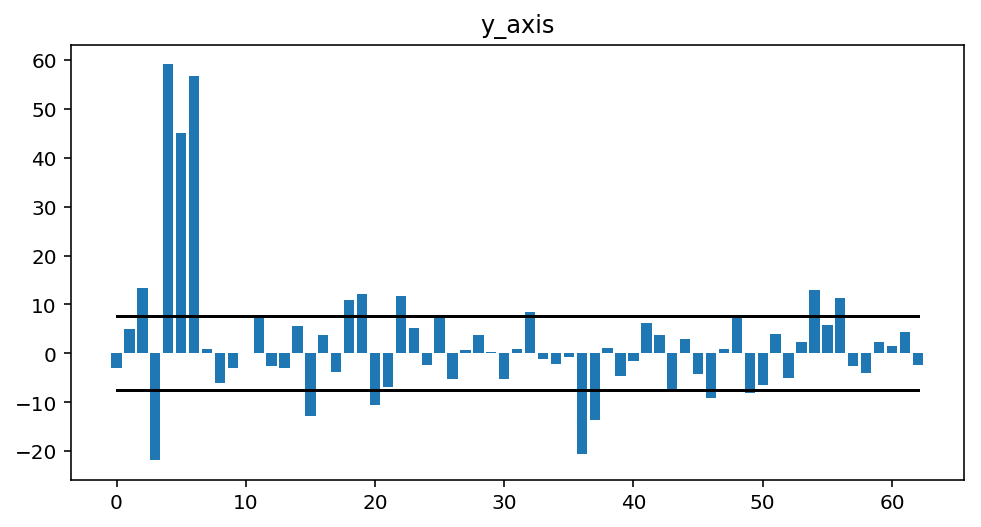

In [425]:



x_pos = np.full(difference[sample].shape[0],10)
y_pos = np.full(difference[sample].shape[0],10)
line=np.arange(0,difference[sample].shape[0])


x_axis = difference[sample][:,y_pos[0]]
y_axis = difference[sample][x_pos[0],:]

plt.imshow(difference_sample)
plt.axis('off')
plt.title('Difference')

plt.plot(line, x_pos, color='black', alpha=0.8)
plt.plot(y_pos, line, color='black', alpha=0.5)
plt.show()

n_sigma_line = np.full(difference[sample].shape[0], n_sigma_psf3)
plt.bar(line, x_axis)
plt.plot(line, n_sigma_line, color='black')
plt.plot(line, -1*n_sigma_line, color='black')
plt.title('x_axis')
plt.show()

plt.bar(line, y_axis)
plt.plot(line, n_sigma_line, color='black')
plt.plot(line, -1*n_sigma_line, color='black')
plt.title('y_axis')
plt.show()


In [323]:
np.full(difference[sample].shape[0], n_sigma_psf3).shape

(63,)

In [324]:
x_axis.shape

(63,)

In [358]:
a = np.empty([0,0])
a

array([], shape=(0, 0), dtype=float64)

In [359]:
a = np.append(a,[2,2], axis=1)
a

ValueError: all the input arrays must have same number of dimensions

In [362]:
a='hola'
len(a)

4

In [366]:
type([a])==list
len([a])

1

In [490]:
class PSF_calculator:

    def __init__(self, difference_image, n_sigma=1.5, psf_iterations=5):
        
        self.n = n_sigma
        self.sigmas = np.empty((0))
        self.n_sigmas = np.empty((0))
        self.diff = difference_image
        
        self.diff_center = int(np.round(self.diff.shape[0]/2))
        
        self.iterative_calculation_PSF(psf_iterations)
        
        
        
    def get_n_sigma(self, image):
        sigma = np.std(image, axis=(0,1))
        n_sigma = self.n*sigma
        self.sigmas = np.append(self.sigmas,sigma)
        self.n_sigmas = np.append(self.n_sigmas,n_sigma)
        return n_sigma
    
    def calculate_PSF(self):
        n_sigma = self.get_n_sigma(self.PSFs[-1])
        PSF = self.diff*(self.diff>n_sigma)
        self.PSFs.append(PSF)
        
    def iterative_calculation_PSF(self, iterations):
        self.sigmas = np.empty((0))
        self.n_sigmas = np.empty((0))
        self.PSFs = [self.diff]
        for i in range(iterations):
            self.calculate_PSF()
            
    def plot_psf_sigmas(self, idx=0, x_pos=32, y_pos=32):
        self.check_availability(self.n_sigmas, idx)
        
        x_pos = np.full(self.diff.shape[0],x_pos)
        y_pos = np.full(self.diff.shape[0],y_pos)
        line = np.arange(0,self.diff.shape[0])
                               
        x_axis = difference[sample][:,y_pos[0]]
        y_axis = difference[sample][x_pos[0],:]
                                   
        self.print_diff()
        plt.plot(line, x_pos, color='black', alpha=0.3)
        plt.plot(y_pos, line, color='black', alpha=0.5)
        plt.show()
        
        n_sigma_line = np.full(self.diff.shape[0], self.n_sigmas[idx])
        plt.bar(line, x_axis)
        plt.plot(line, n_sigma_line, color='black')
        plt.plot(line, -1*n_sigma_line, color='black')
        plt.title(r'x_axis $\sigma$['+str(idx)+r']: $\pm$'+str(self.n_sigmas[idx].round(decimals=3)))
        plt.show()

        plt.bar(line, y_axis)
        plt.plot(line, n_sigma_line, color='black')
        plt.plot(line, -1*n_sigma_line, color='black')
        plt.title(r'y_axis $\sigma$['+str(idx)+r']: $\pm$'+str(self.n_sigmas[idx].round(decimals=3)))
        plt.show()
        
        self.print_diff_psf(idx=idx)
        plt.show()
        
        self.plot_array(self.n_sigmas)
        plt.title(r'$\sigma$´s progretions')
        plt.show()
        
        
    def plot_array(self, array):
        array = np.array(array)
        x = np.arange(0, array.shape[0])
        plt.plot(x,array)

    
    
    
    def print_sample(self, img, titles):
        if type(titles)!=list:
            titles=[titles]
        fig = plt.figure()
        for k, imstr in enumerate(titles):
            ax = fig.add_subplot(1,len(titles),k+1)
            ax.axis('off')
            ax.set_title(imstr)
            if len(titles)==1:
                ax.matshow(img)
                return
            ax.matshow(img[k,...])
        
    def print_diff(self):
        self.print_sample(self.diff, 'Difference')
        
    def print_psf(self, idx=0):
        idx=idx+1
        self.check_availability(self.PSFs, idx)
        self.print_sample(self.PSFs[idx], 'PSF '+str(idx))
        
    def print_diff_psf(self, idx=0):
        idx=idx+1
        self.check_availability(self.PSFs, idx)
        self.print_sample(np.array([self.diff,self.PSFs[idx]]), ['Difference', 'PSF '+str(idx)])
        
    def check_availability(self, array, idx):
        array = np.array(array)
        if array.shape[0]-1<idx:
            self.iterative_calculation_PSF(idx+1)
            
            
            
        
        


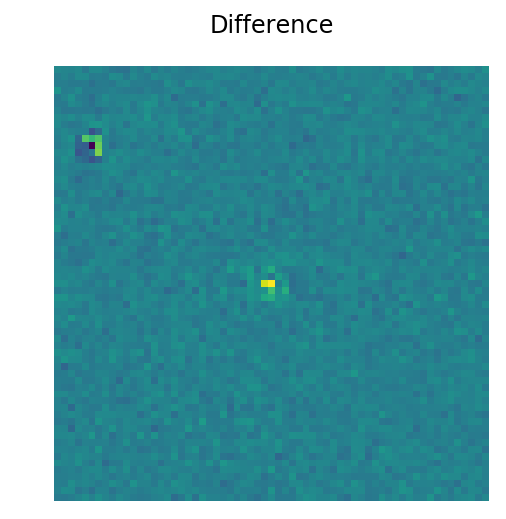

In [493]:
diff1 = PSF_calculator(difference_sample)
diff1.print_diff()

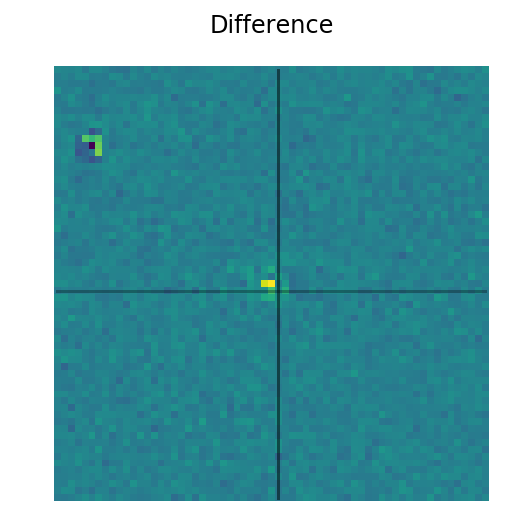

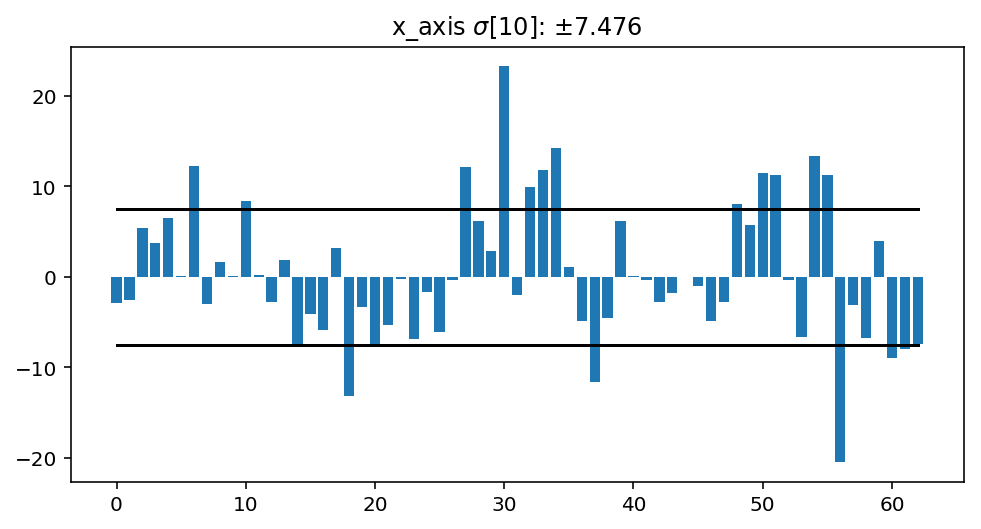

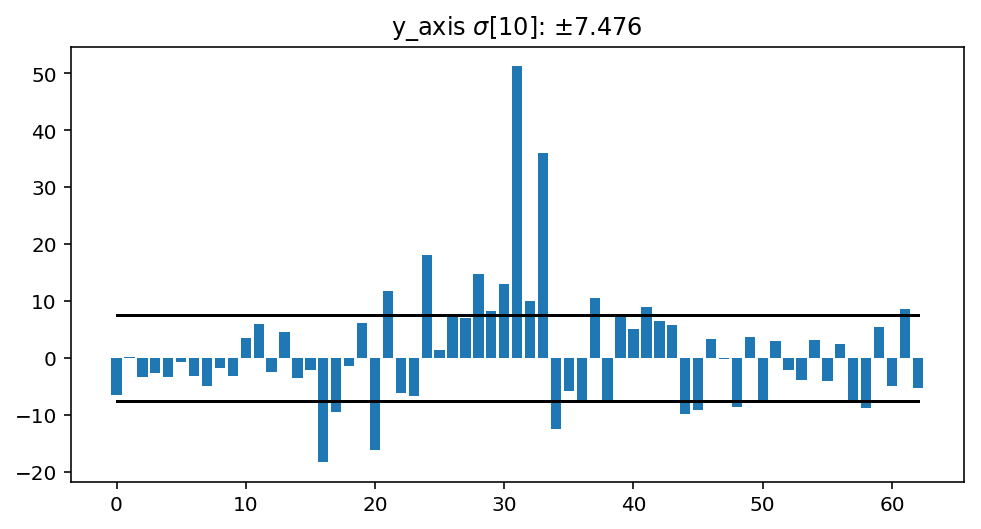

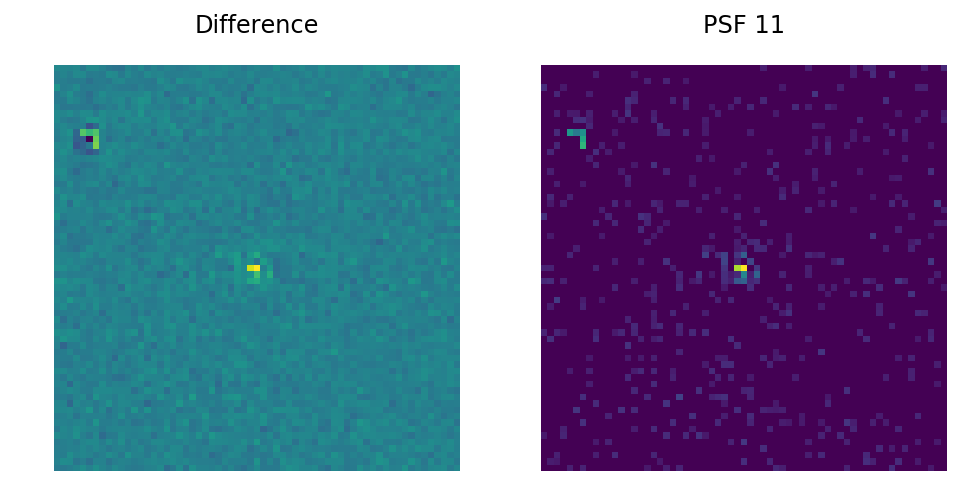

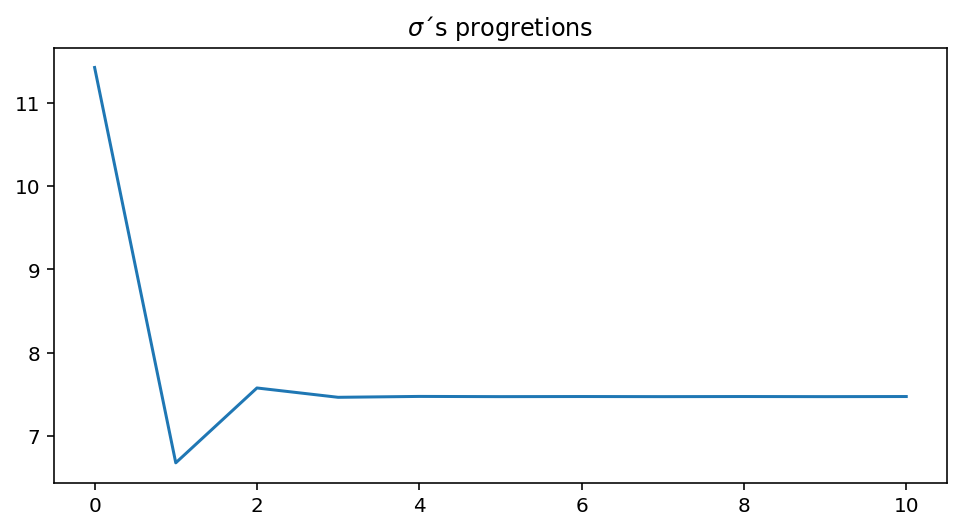

In [494]:
diff1.plot_psf_sigmas(idx=10)

In [496]:
np.array(diff1.PSFs).shape

(12, 63, 63)

In [452]:
diff1.sigmas.shape[0]

5

In [411]:
a = np.append(diff1.PSFs[0],diff1.diff,axis=1)

In [412]:
a.shape

(63, 126)

# PSFS

In [163]:
def get_PSF(diff_reals, N=1.5):
    sigma = np.std(diff_reals, axis=(1,2))
    N_sigma = N*sigma
    PSF = diff_reals*(diff_reals>N_sigma.reshape(diff_reals.shape[0],1,1))
    return PSF, sigma

In [25]:
PSFs, sigmas = get_PSF(reals[...,2])

In [28]:
(sigmas>0).sum()

6054

In [20]:
def print_sample_PSF(img):
    fig = plt.figure()
    for k, imstr in enumerate(['Template', 'Science', 'Difference', 'PSF']):
        ax = fig.add_subplot(1,4,k+1)
        ax.axis('off')
        ax.set_title(imstr)
        ax.matshow(img[...,k])
def print_sample_PSF_diff(img):
    fig = plt.figure()
    for k, imstr in enumerate(['Difference', 'PSF']):
        ax = fig.add_subplot(1,2,k+1)
        ax.axis('off')
        ax.set_title(imstr)
        ax.matshow(img[...,k+2])

In [21]:
PSFs = get_PSF(get_PSF(get_PSF(get_PSF(get_PSF(get_PSF(reals[...,2]))))))

In [22]:
reals_plus_PSF = np.append(reals, PSFs.reshape(PSFs.shape[0],PSFs.shape[1],PSFs.shape[2],1), axis=3)

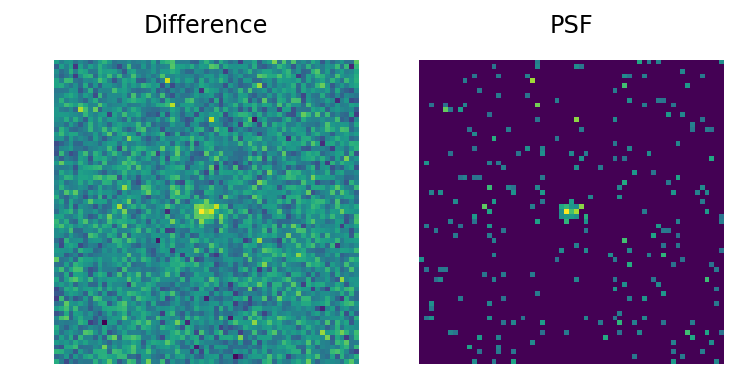

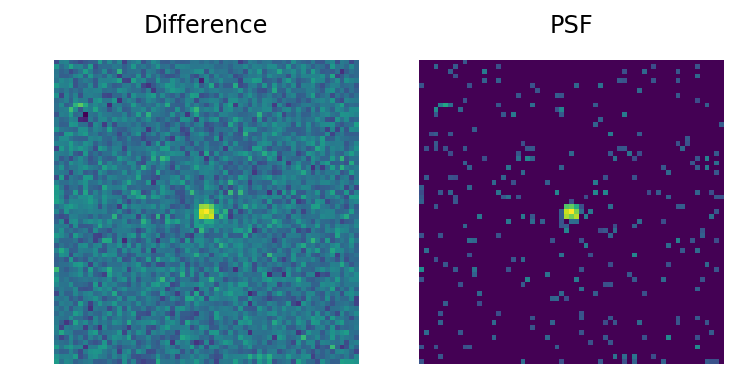

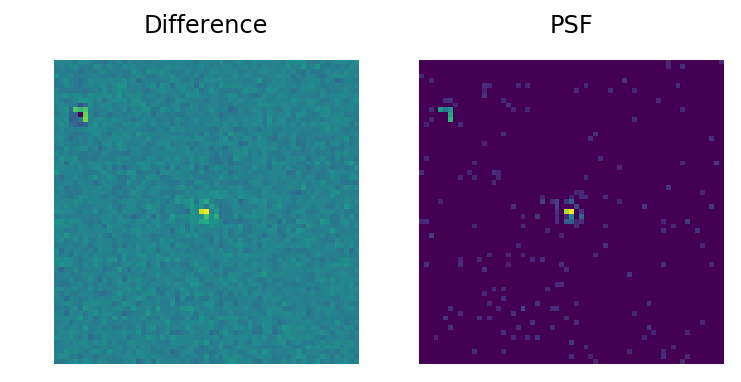

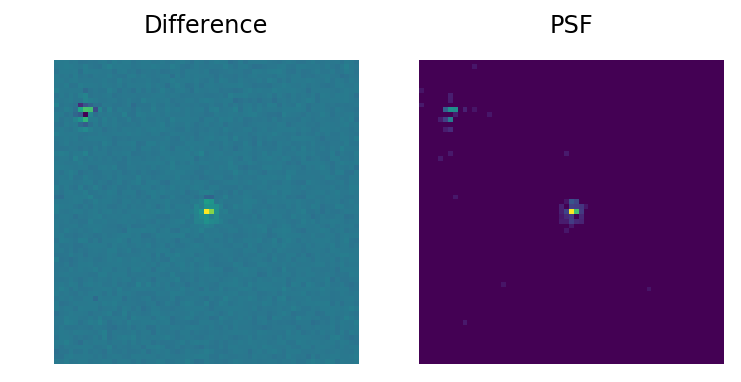

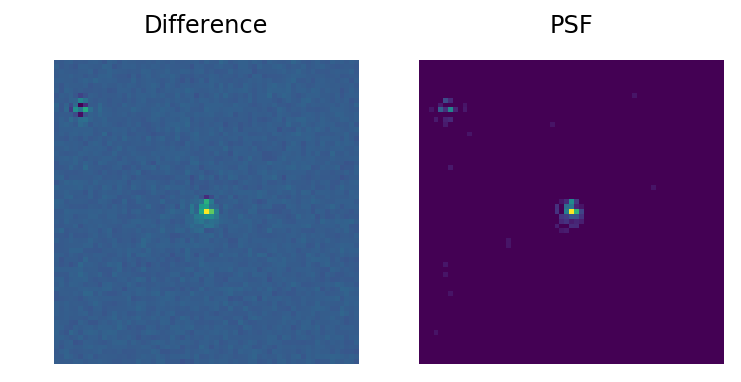

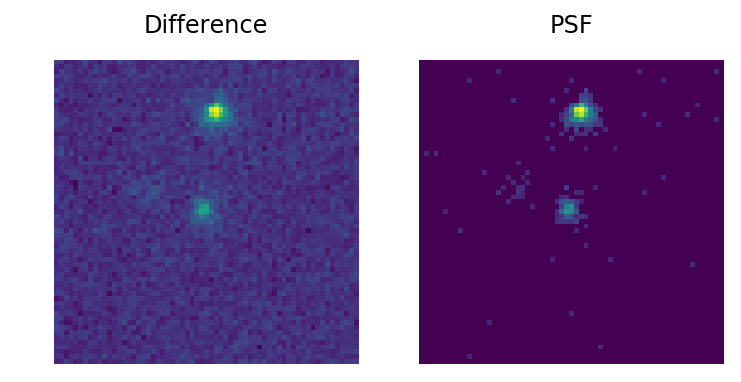

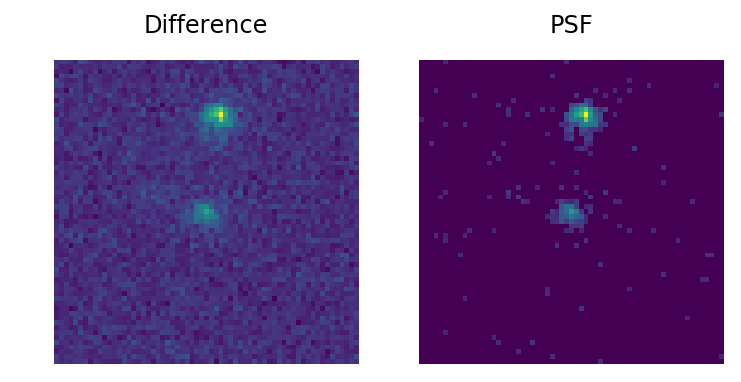

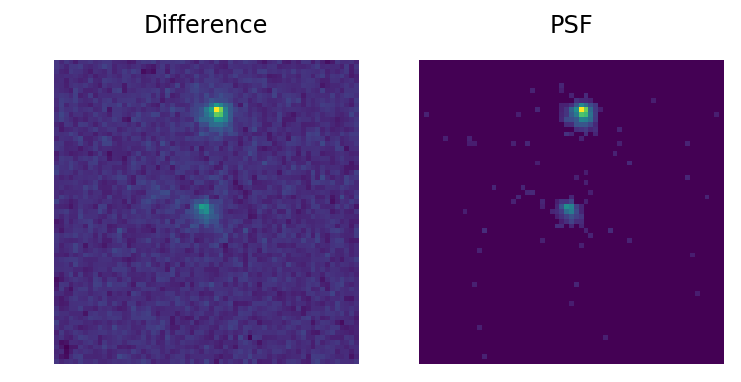

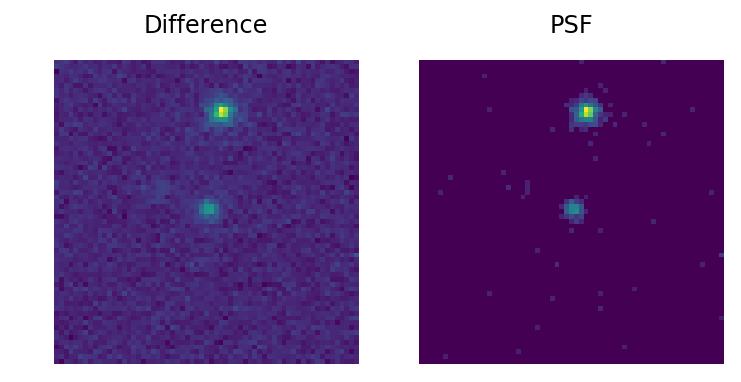

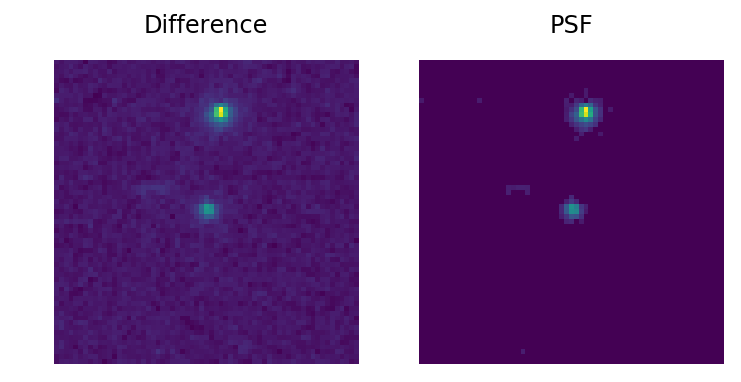

In [23]:
for i in range(10):
    print_sample_PSF_diff(reals_plus_PSF[i,...])

In [199]:
psf1 = get_PSF(reals[...,2])
psf2 = get_PSF(get_PSF(get_PSF(get_PSF(get_PSF(reals[...,2])))))

In [200]:
(psf1-psf2).mean()

0.000102316204